# Introduction 

**This is a basic CNN Model training notebook**

It is based on: 
- Thumbnail images
- Basic data transformation (using Albumentation):
    - resizing images to 512x512
    - normalizing pixel values
- CNN Architecture


**Todos:**

- Learn about Dataset & DataLoader
- add augmentations (albumentation)
- gem pooling

In [1]:
# !pip install --quiet torch_optimizer

In [2]:
!pip install --quiet mlflow dagshub

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.3.1 requires dacite>=1.8, but you have dacite 1.6.0 which is incompatible.
ydata-profiling 4.3.1 requires scipy<1.11,>=1.4.1, but you have scipy 1.11.2 which is incompatible.


In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/tiles-of-cancer-2048px-scale-0-25'):
    for filename in filenames:
        # print(os.path.join(dirname, filename))
        continue



# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:


import os
import gc
import cv2
import datetime
import math
import copy
import time
import random
import glob
from matplotlib import pyplot as plt
from skimage import io


# For data manipulation
import numpy as np
import pandas as pd

# Pytorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torch.cuda import amp
import torchvision

import optuna
from optuna.trial import TrialState

# Utils
import joblib
from tqdm import tqdm
from collections import defaultdict


from PIL import Image
from joblib import Parallel, delayed
from tqdm.auto import tqdm

# Sklearn Imports
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, f1_score

# For Image Models
import timm

import dagshub
from getpass import getpass
import mlflow.pytorch 
from mlflow import MlflowClient

# Albumentations for augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

# For colored terminal text
from colorama import Fore, Back, Style
b_ = Fore.BLUE
sr_ = Style.RESET_ALL

import warnings
# warnings.filterwarnings("ignore")

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
os.environ["MLFLOW_TRACKING_USERNAME"]="Niggl0n"
os.environ["MLFLOW_TRACKING_PASSWORD"] = "7a3590e8c5558d4598dacc7810befa70a4baac9e"
os.environ['MLFLOW_TRACKING_PROJECTNAME'] = "UBC_Cancer_Classification"
dagshub.auth.add_app_token("7a3590e8c5558d4598dacc7810befa70a4baac9e")
mlflow.set_tracking_uri(f'https://dagshub.com/' + os.environ['MLFLOW_TRACKING_USERNAME'] + '/' + os.environ['MLFLOW_TRACKING_PROJECTNAME'] + '.mlflow')

In [6]:
def get_or_create_experiment_id(name):
    exp = mlflow.get_experiment_by_name(name)
    if exp is None:
        exp_id = mlflow.create_experiment(name)
        return exp_id
    return exp.experiment_id

mlflow_experiment_id = get_or_create_experiment_id("UBC_OOS_Outlier_Detection")
mlflow_experiment_id

'2'

In [7]:
CONFIG = {
    "is_submission": False,
    "datetime_now": datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"), 
    "n_fold":5, 
    "test_fold": 0,
    "seed": 42,
    "img_size": 256,
    "train_batch_size": 32,
    "valid_batch_size": 32,
    "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
    "num_epochs": 50,
    "early_stopping": True,
    "patience": 10,
    "optimizer": 'adam',
    "scheduler": 'CosineAnnealingLR',
}

## 1. Data Preparation

In [8]:
ROOT_DIR = '/kaggle/input/UBC-OCEAN'
TRAIN_DIR = '/kaggle/input/tiles-of-cancer-2048px-scale-0-25/'
TEST_DIR = '/kaggle/input/UBC-OCEAN/test_thumbnails'

# ALT_TEST_DIR = '/kaggle/input/UBC-OCEAN/test_images'
# TMA_TRAIN_DIR = '/kaggle/input/UBC-OCEAN/train_images'

def get_train_file_path(df_train_row):
    return f"{TRAIN_DIR}/{df_train_row.image_id}_thumbnail.png"

def get_test_file_path(image_id):
    if os.path.exists(f"{TEST_DIR}/{image_id}_thumbnail.png"):
        return f"{TEST_DIR}/{image_id}_thumbnail.png"
    else:
        return f"{ALT_TEST_DIR}/{image_id}.png"



## Create Train and Holdout Set

In [9]:
train_images = sorted(glob.glob(f"{TRAIN_DIR}/*.png"))
df_train = pd.read_csv("/kaggle/input/UBC-OCEAN/train.csv")
print(df_train.shape)
df_train['file_path'] = df_train.apply(lambda row: get_train_file_path(row), axis=1)
# only consider WSI / Thumbnail images
#df_train = df_train[ 
#    df_train["file_path"].isin(train_images) ].reset_index(drop=True)
print(df_train.shape)

# encode to numericalt target
encoder = LabelEncoder()
df_train['target_label'] = encoder.fit_transform(df_train['label'])

# save encoder
with open("label_encoder_"+ CONFIG["datetime_now"] +".pkl", "wb") as fp:
    joblib.dump(encoder, fp)
    
# use stratified K Fold for crossvalidation 
skf = StratifiedKFold(n_splits=CONFIG['n_fold'], shuffle=True, random_state=CONFIG["seed"])

for fold, ( _, val_) in enumerate(skf.split(X=df_train, y=df_train.target_label)):
    df_train.loc[val_ , "kfold"] = int(fold)
    
df_holdout = df_train[df_train["kfold"].isin([4])].reset_index(drop=True)
df_train = df_train[df_train["kfold"].isin([0,1,2,3])].reset_index(drop=True)
df_train = df_train[df_train["label"]!="LGSC"].reset_index(drop=True)

print(f"Shape Training Set: {df_train.shape}, Shape Holdout Set: {df_holdout.shape}")

df_train.head()

(538, 5)
(538, 6)
Shape Training Set: (393, 8), Shape Holdout Set: (107, 8)


,image_id,label,image_width,image_height,is_tma,file_path,target_label,kfold
0,4,HGSC,23785,20008,False,/kaggle/input/tiles-of-cancer-2048px-scale-0-2...,2,3.0
1,286,EC,37204,30020,False,/kaggle/input/tiles-of-cancer-2048px-scale-0-2...,1,2.0
2,431,HGSC,39991,40943,False,/kaggle/input/tiles-of-cancer-2048px-scale-0-2...,2,0.0
3,706,HGSC,75606,25965,False,/kaggle/input/tiles-of-cancer-2048px-scale-0-2...,2,3.0
4,970,HGSC,32131,18935,False,/kaggle/input/tiles-of-cancer-2048px-scale-0-2...,2,3.0


## Create Pytorch Dataset

In [10]:
class CancerTilesDataset(Dataset):
    def __init__(
        self,
        df_data,
        path_img_dir: str =  '',
        transforms = None,
        mode: str = 'train',
        labels_lut = None,
        white_thr: int = 225,
        thr_max_bg: float = 0.2,
        split: float = 0.90
    ):
        assert os.path.isdir(path_img_dir)
        self.path_img_dir = path_img_dir
        self.transforms = transforms
        self.mode = mode
        self.white_thr = white_thr
        self.thr_max_bg = thr_max_bg
        self.split = split

        self.data = df_data
        self.labels_unique = sorted(self.data["label"].unique())
        self.labels_lut = labels_lut or {lb: i for i, lb in enumerate(self.labels_unique)}
        # shuffle data
        self.data = self.data.sample(frac=1, random_state=42).reset_index(drop=True)

        # split dataset
        assert 0.0 <= self.split <= 1.0
        frac = int(self.split * len(self.data))
        self.data = self.data[:frac] if mode in ["train", "test"] else self.data[frac:]
        self.img_dirs = [glob.glob(os.path.join(path_img_dir, str(idx), "*.png")) for idx in self.data["image_id"]]
        #print(f"missing: {sum([not os.path.isfile(os.path.join(self.path_img_dir, im))
        #                       for im in self.img_names])}")
        # self.labels = list(self.data['label'])
        self.labels =  self.data.target_label.values

    def __getitem__(self, idx: int) -> tuple:
        random.shuffle(self.img_dirs[idx])
        for img_path in self.img_dirs[idx]:
            assert os.path.isfile(img_path), f"missing: {img_path}"
            tile = cv2.imread(img_path)
            tile = cv2.cvtColor(tile, cv2.COLOR_BGR2RGB)
        
            # tile = np.array(Image.open(img_path))[..., :3]
            black_bg = np.sum(tile, axis=2) == 0
            tile[black_bg, :] = 255
            mask_bg = np.mean(tile, axis=2) > self.white_thr
            if np.sum(mask_bg) < (np.prod(mask_bg.shape) * self.thr_max_bg):
                break

        # augmentation
        if self.transforms:
            tile = self.transforms(image=tile)["image"]
        #print(f"img dim: {img.shape}")
        return {
            "image": tile,
            "label": torch.tensor(self.labels[idx], dtype=torch.long)
               }

    def __len__(self) -> int:
        return len(self.data)

In [11]:
data_transforms = {
    "train": A.Compose([
        A.Resize(CONFIG['img_size'], CONFIG['img_size']),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=15, p=0.25),
        A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.25),
        A.CoarseDropout(p=0.2),
        #A.Cutout(p=0.2),
        A.Normalize(
            mean=0.0, std=1.0,
            p=1.0
        ),
        ToTensorV2()], p=1.),
    
    "valid": A.Compose([
        A.Resize(CONFIG['img_size'], CONFIG['img_size']),
        A.Normalize(
            mean=0.0, std=1.0,
            p=1.0
        ),
        ToTensorV2()], p=1.)
}

## 2. Model Creation

In [12]:
"""
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()

        # Encoder
        self.enc1 = nn.Sequential(
            nn.Conv2d(3, 64, 3, stride=2, padding=1), 
            nn.ReLU(True),
            nn.BatchNorm2d(64)
        )
        self.enc2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, stride=2, padding=1), 
            nn.ReLU(True),
            nn.BatchNorm2d(128)
        )
        self.enc3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, stride=2, padding=1), 
            nn.ReLU(True),
            nn.BatchNorm2d(256)
        )
        self.enc4 = nn.Sequential(
            nn.Conv2d(256, 512, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.BatchNorm2d(512),
            nn.Dropout(0.5)  # Adding dropout for regularization
        )

        # Decoder
        self.dec1 = nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1)
        self.dec1_bn = nn.BatchNorm2d(256)
        self.dec2 = nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1)
        self.dec2_bn = nn.BatchNorm2d(128)
        self.dec3 = nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1)
        self.dec3_bn = nn.BatchNorm2d(64)
        self.dec4 = nn.ConvTranspose2d(64, 3, 4, stride=2, padding=1)

        # Skip Connections
        # self.up_sample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)   # Output size: (batch, 64, 256, 256)
        enc2 = self.enc2(enc1)  # Output size: (batch, 128, 128, 128)
        enc3 = self.enc3(enc2)  # Output size: (batch, 256, 64, 64)
        enc4 = self.enc4(enc3)  # Output size: (batch, 512, 32, 32)

        # Decoder with skip connections
        dec1 = self.dec1_bn(self.dec1(enc4))  # Output size: (batch, 256, 64, 64)
        dec1 = dec1 + enc3  # skip connection from enc3 to dec1
        dec2 = self.dec2_bn(self.dec2(dec1))  # Output size: (batch, 128, 128, 128)
        dec2 = dec2 + enc2  # skip connection from enc2 to dec2
        dec3 = self.dec3_bn(self.dec3(dec2))  # Output size: (batch, 64, 256, 256)
        dec3 = dec3 + enc1  # skip connection from enc1 to dec3
        dec4 = torch.sigmoid(self.dec4(dec3))  # Output size: (batch, 3, 512, 512)
        return dec4"""


class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()

        # Encoder
        self.enc1 = nn.Sequential(
            nn.Conv2d(3, 64, 3, stride=2, padding=1), 
            nn.ReLU(True),
            nn.BatchNorm2d(64)
        )
        self.enc2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, stride=2, padding=1), 
            nn.ReLU(True),
            nn.BatchNorm2d(128)
        )
        self.enc3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, stride=2, padding=1), 
            nn.ReLU(True),
            nn.BatchNorm2d(256)
        )

        # Decoder
        self.dec1 = nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1)
        self.dec1_bn = nn.BatchNorm2d(128)
        self.dec2 = nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1)
        self.dec2_bn = nn.BatchNorm2d(64)
        self.dec3 = nn.ConvTranspose2d(64, 3, 4, stride=2, padding=1)

    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)   # Output size: (batch, 64, 128, 128)
        enc2 = self.enc2(enc1)  # Output size: (batch, 128, 64, 64)
        enc3 = self.enc3(enc2)  # Output size: (batch, 256, 32, 32)

        # Decoder
        dec1 = self.dec1_bn(self.dec1(enc3))  # Output size: (batch, 128, 64, 64)
        dec2 = self.dec2_bn(self.dec2(dec1))  # Output size: (batch, 64, 128, 128)
        dec3 = torch.sigmoid(self.dec3(dec2))  # Output size: (batch, 3, 256, 256)

        return dec3



## 3. Training

In [13]:
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0, path='checkpoint.pth', trace_func=print):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decreases.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model to path {self.path}')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss


In [14]:


def fetch_scheduler(optimizer):
    if CONFIG['scheduler'] == 'CosineAnnealingLR':
        CONFIG['T_max'] = 30
        CONFIG['min_lr'] = 1e-6
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=CONFIG['T_max'], 
                                                   eta_min=CONFIG['min_lr'], verbose=False)
    elif CONFIG['scheduler'] == 'CosineAnnealingWarmRestarts':
        CONFIG['T_0'] = 10
        CONFIG['T_mult'] = 2
        CONFIG['min_lr'] = 1e-6
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=CONFIG['T_0'], T_mult=CONFIG['T_mult'],
                                                             eta_min=CONFIG['min_lr'], verbose=False)
    elif CONFIG['scheduler'] == 'ReduceLROnPlateau':
        scheduler =  ReduceLROnPlateau(optimizer, mode='min', factor=kwargs.get('factor', 0.1), patience=kwargs.get('patience', 5), verbose=False)
    elif CONFIG['scheduler'] == 'LambdaLR':
        scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda)
    elif CONFIG['scheduler'] == None:
        return None
        
    return scheduler

def get_optimizer(optimizer_name, model):
    if optimizer_name.lower() == "adam":
        CONFIG['learning_rate'] = 1e-3
        CONFIG['weight_decay'] = 1e-3
        optimizer = optim.Adam(model.parameters(), lr=CONFIG['learning_rate'],  weight_decay=CONFIG['weight_decay'])
    elif optimizer_name.lower() == "sgd":
        CONFIG['learning_rate'] = 1e-3
        CONFIG['weight_decay'] = 1e-3
        CONFIG['momentum'] = 1e-3
        optimizer = optim.SGD(model.parameters(), lr=CONFIG['learning_rate'], momentum=CONFIG['momentum'], weight_decay=CONFIG['weight_decay'])
    elif optimizer_name.lower() == "radam":
        CONFIG['learning_rate'] = 1e-3
        CONFIG['weight_decay'] = 0
        CONFIG['betas'] = (0.9, 0.999)
        CONFIG['eps'] = 1e-8
        optimizer = torch_optimizer.RAdam(
            model.parameters(),
            lr= CONFIG['learning_rate'],
            betas=CONFIG['betas'],
            eps=CONFIG['eps'],
            weight_decay=CONFIG['weight_decay'],
        )
    elif optimizer_name.lower() == "rmsprop":
        CONFIG['learning_rate'] = 0.256
        CONFIG['alpha'] = 0.9
        CONFIG['momentum'] = 0.9
        CONFIG['weight_decay'] = 1e-5
        optimizer = optim.RMSprop(model.parameters(), lr=CONFIG['learning_rate'], alpha=CONFIG['learning_rate'], 
                                  momentum=CONFIG['learning_rate'], weight_decay=CONFIG['learning_rate'])
    else:
        raise ValueError("Invalid Optimizer given!")
    return optimizer
    



In [15]:
def train_one_epoch(model, train_loader, optimizer, criterion, device, writer, epoch, scheduler=None):
    if torch.cuda.is_available():
        print("[INFO] Using GPU: {}\n".format(torch.cuda.get_device_name()))
    model.train()
    train_loss = 0.0
    bar = tqdm(enumerate(train_loader), total=len(train_loader))
    for step, data in bar:
        images = data['image'].to(device, dtype=torch.float)
        
        optimizer.zero_grad()
        reconstructed = model(images)
        loss = criterion(reconstructed, images)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        # Update learning rate using the scheduler
        if scheduler:
            scheduler.step()
        
        # Log the training loss to TensorBoard
        #writer.add_scalar('loss/train_batch', loss.item(), epoch * len(train_loader) + step)
    
    train_loss /= len(train_loader.dataset)
    # Log the average training loss for the epoch to TensorBoard
    # writer.add_scalar('loss/train_epoch', train_loss, epoch)
    # gc.collect()
    return train_loss

def validate_one_epoch(model, valid_loader, criterion, device, writer, epoch):
    model.eval()
    valid_loss = 0.0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        bar_val = tqdm(enumerate(valid_loader), total=len(valid_loader))
        for step, data in bar_val:
            images = data['image'].to(device, dtype=torch.float)
            
            reconstructed = model(images)
            loss = criterion(reconstructed, images)
            valid_loss += loss.item() * images.size(0)
            # writer.add_scalar('loss/valid_batch', loss.item(), epoch * len(valid_loader) + step)
    valid_loss /= len(valid_loader.dataset)

    # Logging to TensorBoard
    # writer.add_scalar('loss/val_epoch', valid_loss, epoch)
    return valid_loss

def train_model(model, train_loader, valid_loader, optimizer, criterion, device, num_epochs, scheduler, save_model_path=None):
    model_name = "model_epochs" + str(CONFIG["num_epochs"]) + "_bs"+str(CONFIG["train_batch_size"] )+ "_opt" +CONFIG["optimizer"]+ "_sched" + CONFIG["scheduler"] + "_lr"+str(CONFIG["learning_rate"])+ "_wd" + str(CONFIG["weight_decay"])
    print(f"Training model: {model_name}")
    datetime_now =  datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    if not save_model_path:
        save_model_path = 'best_model_checkpoint' + datetime_now + '.pth'
    print(f"Path for saving model: {save_model_path}")
    # Initialize TensorBoard writer
    writer = SummaryWriter('logs/fit/' + model_name)
    early_stopping = EarlyStopping(patience=CONFIG["patience"], verbose=True, path=save_model_path)
    #if scheduler_type:
    #    print(f"Define {scheduler_type} scheduler")
    #    scheduler = get_lr_scheduler(optimizer, scheduler_type, num_epochs=num_epochs)
    
    for epoch in range(num_epochs):
        train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device, writer, epoch, scheduler)
        valid_loss = validate_one_epoch(model, valid_loader, criterion, device, writer, epoch)
        print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss:.4f}, Validation loss: {valid_loss:.4f}")
        
        # Log metrics for each epoch
        mlflow.log_metrics({
            'epoch': epoch,
            'train_loss': train_loss,
            'valid_loss': valid_loss,
        }, step=epoch)
    
        # Call early stopping
        if CONFIG["early_stopping"]:
            early_stopping(valid_loss, model)
            if early_stopping.early_stop:
                print("Early stopping")
                break
            
    writer.close()
    return train_loss, valid_loss, save_model_path
    # Load the last checkpoint with the best model
    #model.load_state_dict(torch.load('best_model_checkpoint.pth'))



In [16]:
def test_on_holdout(model, CONFIG, df_test, TRAIN_DIR=None, val_size=1.0):
    if not CONFIG["is_submission"]:
        model.eval()
        test_dataset = CancerTilesDataset(df_test, TRAIN_DIR, transforms=data_transforms["valid"], mode="test", split=1.0)
        test_loader = DataLoader(test_dataset, batch_size=CONFIG['valid_batch_size'], 
                                  num_workers=2, shuffle=False, pin_memory=True)

        reconstructions = []
        test_images = []
        errors = []
        test_mae = 0.0
            
        with torch.no_grad():
            bar = tqdm(enumerate(test_loader), total=len(test_loader))
            for step, data in bar: 
                # print(step)
                images = data['image'].to(CONFIG["device"], dtype=torch.float)
            
                reconstructed = model(images)
                mae = criterion(reconstructed, images)
                test_images.append(images.detach().cpu().numpy() )
                reconstructions.append(reconstructed.detach().cpu().numpy() )
                errors.append(mae)
                test_mae += mae.item() * images.size(0)
        test_mae /= len(test_loader.dataset)

        #preds = np.concatenate(preds).flatten()
        #labels_list = np.concatenate(labels_list).flatten()
        #pred_labels = encoder.inverse_transform( preds )
        #mlflow.log_metrics({'test_mae': test_mae})
        return reconstructions, test_images, errors, test_mae
    else:
        print("Skip validation on training set due to submission!")
        return None

In [17]:
def get_dataloaders(df):
    # df_train = df[df["kfold"]!=fold].reset_index(drop=True)
    train_dataset = CancerTilesDataset(df_train, TRAIN_DIR, transforms=data_transforms["train"], mode="train")
    train_loader = DataLoader(train_dataset, batch_size=CONFIG['train_batch_size'], 
                              num_workers=2, shuffle=False, pin_memory=True)
    valid_dataset = CancerTilesDataset(df_train, TRAIN_DIR, transforms=data_transforms["valid"], mode="valid")
    valid_loader = DataLoader(valid_dataset, batch_size=CONFIG['valid_batch_size'], 
                              num_workers=2, shuffle=False, pin_memory=True)
    print(f"Len Train Dataset: {len(train_dataset)}, Len Validation Dataset: {len(valid_dataset)}" )
    return train_loader, valid_loader, df_train


In [18]:
def print_logged_info(r):
    tags = {k: v for k, v in r.data.tags.items() if not k.startswith("mlflow.")}
    artifacts = [f.path for f in MlflowClient().list_artifacts(r.info.run_id, "model")]
    print(f"run_id: {r.info.run_id}")
    print(f"artifacts: {artifacts}")
    print(f"params: {r.data.params}")
    print(f"metrics: {r.data.metrics}")
    print(f"tags: {tags}")


In [19]:
# separate train and test dataset
df_test = df_train[df_train["kfold"]==CONFIG["test_fold"]].reset_index(drop=True)
df_train = df_train[df_train["kfold"]!=CONFIG["test_fold"]].reset_index(drop=True)



with mlflow.start_run(experiment_id=mlflow_experiment_id) as run:
    
    train_loader, valid_loader, df_train_fold = get_dataloaders(df_train.copy())

    model = ConvAutoencoder()
    model.to(CONFIG['device']);
    criterion = nn.MSELoss()

    optimizer = get_optimizer(CONFIG["optimizer"], model)
    scheduler = fetch_scheduler(optimizer)

    _, _, save_model_path = train_model(model, train_loader, valid_loader, optimizer, criterion, CONFIG["device"], CONFIG["num_epochs"], scheduler)
    model.load_state_dict(torch.load(save_model_path))

    #print("Validate on Holdout Set:")
    #reconstructions, test_images, errors, test_mae = test_on_holdout(model, CONFIG, df_test, TRAIN_DIR, val_size=1)
    #df_test_file_path = "df_test_results.csv"
    #df_test.to_csv(df_test_file_path, index=False)
    # mlflow.log_artifact(df_test_file_path)

    mlflow.log_params(CONFIG)
    mlflow.pytorch.log_model(model, "model")
    mlflow.log_artifact(save_model_path)

print_logged_info(mlflow.get_run(run_id=run.info.run_id))

Len Train Dataset: 264, Len Validation Dataset: 30
Training model: model_epochs50_bs32_optadam_schedCosineAnnealingLR_lr0.001_wd0.001
Path for saving model: best_model_checkpoint2023-11-15_20-10-39.pth
[INFO] Using GPU: Tesla P100-PCIE-16GB



  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/50 - Train loss: 0.0770, Validation loss: 0.0172
Validation loss decreased (inf --> 0.017171). Saving model to path best_model_checkpoint2023-11-15_20-10-39.pth
[INFO] Using GPU: Tesla P100-PCIE-16GB



  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/50 - Train loss: 0.0518, Validation loss: 0.0207
EarlyStopping counter: 1 out of 10
[INFO] Using GPU: Tesla P100-PCIE-16GB



  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/50 - Train loss: 0.0421, Validation loss: 0.0255
EarlyStopping counter: 2 out of 10
[INFO] Using GPU: Tesla P100-PCIE-16GB



  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/50 - Train loss: 0.0433, Validation loss: 0.0263
EarlyStopping counter: 3 out of 10
[INFO] Using GPU: Tesla P100-PCIE-16GB



  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/50 - Train loss: 0.0409, Validation loss: 0.0263
EarlyStopping counter: 4 out of 10
[INFO] Using GPU: Tesla P100-PCIE-16GB



  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/50 - Train loss: 0.0329, Validation loss: 0.0203
EarlyStopping counter: 5 out of 10
[INFO] Using GPU: Tesla P100-PCIE-16GB



  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/50 - Train loss: 0.0260, Validation loss: 0.0307
EarlyStopping counter: 6 out of 10
[INFO] Using GPU: Tesla P100-PCIE-16GB



  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/50 - Train loss: 0.0215, Validation loss: 0.0259
EarlyStopping counter: 7 out of 10
[INFO] Using GPU: Tesla P100-PCIE-16GB



  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/50 - Train loss: 0.0178, Validation loss: 0.0195
EarlyStopping counter: 8 out of 10
[INFO] Using GPU: Tesla P100-PCIE-16GB



  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/50 - Train loss: 0.0170, Validation loss: 0.0119
Validation loss decreased (0.017171 --> 0.011874). Saving model to path best_model_checkpoint2023-11-15_20-10-39.pth
[INFO] Using GPU: Tesla P100-PCIE-16GB



  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/50 - Train loss: 0.0164, Validation loss: 0.0079
Validation loss decreased (0.011874 --> 0.007911). Saving model to path best_model_checkpoint2023-11-15_20-10-39.pth
[INFO] Using GPU: Tesla P100-PCIE-16GB



  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/50 - Train loss: 0.0171, Validation loss: 0.0118
EarlyStopping counter: 1 out of 10
[INFO] Using GPU: Tesla P100-PCIE-16GB



  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/50 - Train loss: 0.0155, Validation loss: 0.0117
EarlyStopping counter: 2 out of 10
[INFO] Using GPU: Tesla P100-PCIE-16GB



  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/50 - Train loss: 0.0142, Validation loss: 0.0070
Validation loss decreased (0.007911 --> 0.007033). Saving model to path best_model_checkpoint2023-11-15_20-10-39.pth
[INFO] Using GPU: Tesla P100-PCIE-16GB



  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/50 - Train loss: 0.0133, Validation loss: 0.0097
EarlyStopping counter: 1 out of 10
[INFO] Using GPU: Tesla P100-PCIE-16GB



  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/50 - Train loss: 0.0120, Validation loss: 0.0057
Validation loss decreased (0.007033 --> 0.005707). Saving model to path best_model_checkpoint2023-11-15_20-10-39.pth
[INFO] Using GPU: Tesla P100-PCIE-16GB



  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/50 - Train loss: 0.0156, Validation loss: 0.0051
Validation loss decreased (0.005707 --> 0.005139). Saving model to path best_model_checkpoint2023-11-15_20-10-39.pth
[INFO] Using GPU: Tesla P100-PCIE-16GB



  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/50 - Train loss: 0.0121, Validation loss: 0.0102
EarlyStopping counter: 1 out of 10
[INFO] Using GPU: Tesla P100-PCIE-16GB



  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/50 - Train loss: 0.0125, Validation loss: 0.0154
EarlyStopping counter: 2 out of 10
[INFO] Using GPU: Tesla P100-PCIE-16GB



  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/50 - Train loss: 0.0124, Validation loss: 0.0096
EarlyStopping counter: 3 out of 10
[INFO] Using GPU: Tesla P100-PCIE-16GB



  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 21/50 - Train loss: 0.0117, Validation loss: 0.0064
EarlyStopping counter: 4 out of 10
[INFO] Using GPU: Tesla P100-PCIE-16GB



  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 22/50 - Train loss: 0.0102, Validation loss: 0.0056
EarlyStopping counter: 5 out of 10
[INFO] Using GPU: Tesla P100-PCIE-16GB



  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 23/50 - Train loss: 0.0099, Validation loss: 0.0060
EarlyStopping counter: 6 out of 10
[INFO] Using GPU: Tesla P100-PCIE-16GB



  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 24/50 - Train loss: 0.0089, Validation loss: 0.0053
EarlyStopping counter: 7 out of 10
[INFO] Using GPU: Tesla P100-PCIE-16GB



  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 25/50 - Train loss: 0.0091, Validation loss: 0.0056
EarlyStopping counter: 8 out of 10
[INFO] Using GPU: Tesla P100-PCIE-16GB



  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 26/50 - Train loss: 0.0092, Validation loss: 0.0069
EarlyStopping counter: 9 out of 10
[INFO] Using GPU: Tesla P100-PCIE-16GB



  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 27/50 - Train loss: 0.0093, Validation loss: 0.0057
EarlyStopping counter: 10 out of 10
Early stopping


/opt/conda/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


run_id: a371d91cebce446baca3484c258b0d80
artifacts: ['model/MLmodel', 'model/conda.yaml', 'model/data', 'model/python_env.yaml', 'model/requirements.txt']
params: {'is_submission': 'False', 'datetime_now': '2023-11-15_20-10-31', 'n_fold': '5', 'test_fold': '0', 'seed': '42', 'img_size': '256', 'train_batch_size': '32', 'valid_batch_size': '32', 'device': 'cuda:0', 'num_epochs': '50', 'early_stopping': 'True', 'patience': '10', 'optimizer': 'adam', 'scheduler': 'CosineAnnealingLR', 'learning_rate': '0.001', 'weight_decay': '0.001', 'T_max': '30', 'min_lr': '1e-06'}
metrics: {'train_loss': 0.00928826751469663, 'valid_loss': 0.00565395224839449, 'epoch': 26.0}
tags: {}


In [20]:
reconstructions, test_images, errors, test_mae = test_on_holdout(model, CONFIG, df_holdout, TRAIN_DIR, val_size=1)

  0%|          | 0/4 [00:00<?, ?it/s]

### Evaluate on Holdout Set

In [21]:
def calculate_reconstruction_error(reconstructed, original):
    """
    Calculate the Mean Squared Error between the original and reconstructed images.

    Parameters:
    - reconstructed: Tensor of reconstructed images from the autoencoder.
    - original: Tensor of original images.

    Returns:
    - A Tensor of MSE values for each image in the batch.
    """
    batch_size = original.size(0)
    mse_loss = nn.MSELoss(reduction='none')
    errors = mse_loss(reconstructed, original)  # Compute MSE for each pixel
    errors = errors.view(batch_size, -1)  # Flatten the error tensors
    mean_errors = errors.mean(1)  # Calculate mean error for each image in the batch
    return mean_errors


def determine_threshold(model, validation_loader, device, n_sd_th=2):
    model.eval()
    reconstruction_errors = []

    with torch.no_grad():
        bar = tqdm(enumerate(validation_loader), total=len(validation_loader))
        for step, data in bar: 
            # print(step)
            images = data['image'].to(device, dtype=torch.float)
            reconstructed = model(images)
            error = calculate_reconstruction_error(reconstructed, images)
            reconstruction_errors.extend(error.tolist())

    # Compute mean and standard deviation of reconstruction errors
    error_mean = np.mean(reconstruction_errors)
    error_std = np.std(reconstruction_errors)

    # Determine threshold (e.g., mean + 2*std)
    threshold = error_mean + n_sd_th * error_std
    return threshold, reconstruction_errors



  0%|          | 0/1 [00:00<?, ?it/s]

0.008654662457887059


(array([7., 6., 7., 5., 3., 0., 0., 1., 0., 1.]),
 array([0.00236167, 0.00328036, 0.00419905, 0.00511774, 0.00603643,
        0.00695512, 0.00787381, 0.0087925 , 0.0097112 , 0.01062989,
        0.01154858]),
 <BarContainer object of 10 artists>)

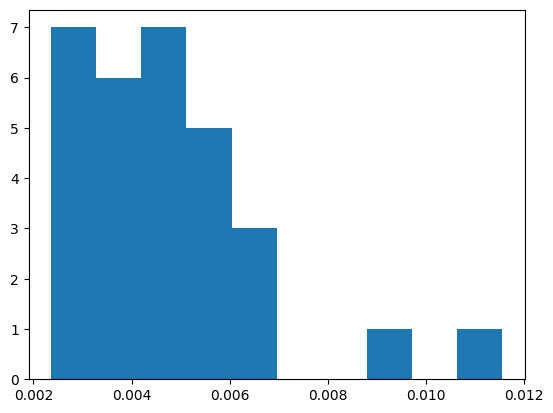

In [22]:
threshold, reconstruction_errors = determine_threshold(model, valid_loader, CONFIG["device"])
print(threshold)
plt.hist(reconstruction_errors)

